<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Sentiment_analysis_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing Necessary Libraries
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from gensim import models



import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import os
import re
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Tripadvisor Datasource.csv to Tripadvisor Datasource.csv


In [ ]:
import io
review_df = pd.read_csv(io.BytesIO(uploaded['Tripadvisor Datasource.csv']))

In [ ]:
review_df.head()


,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Rating
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,5
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,5
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,5
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,4
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,5


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#Explore Data
review_df.shape
type(review_df)
review_df.size
review_df.shape
review_df.head()
review_df.tail()

(701, 7)

pandas.core.frame.DataFrame

4907

(701, 7)

,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Rating
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,5
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,5
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,5
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,4
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,5


,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Rating
696,g297628-d1483784,Melange Astris,r727852519,Value for money ...,Ravi Venkatraman,One of the finest property in the Center of Be...,5
697,g297628-d1483784,Melange Astris,r720634348,Third and last time,GSVCA,This was our third time staying at the Melange...,3
698,g297628-d1483784,Melange Astris,r714050308,First class hotel and absolute bargain,Fast_Mini,9th hotel in 13 days during a business trip ac...,5
699,g297628-d1483784,Melange Astris,r706524762,great stay..,VRam,My most profferers stay in Bangalore. Hotel is...,5
700,g297628-d1483784,Melange Astris,r517289155,Pleasant stay !!,WonderSpinach,Was here on business for 2 days.. the hotel is...,4


In [ ]:
review_df.Rating.value_counts()

5    554
4     98
3     28
1     13
2      8
Name: Rating, dtype: int64

In [ ]:
print("Mean rating : {}".format(review_df['Rating'].mean()))
print("Mean rating standard deviation: {}".format(review_df['Rating'].std()))

Mean rating : 4.671897289586306
Mean rating standard deviation: 0.7695419570895506


(array([ 13.,   0.,   8.,   0.,  28.,   0.,  98.,   0., 554.]),
 array([0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1]),
 <a list of 9 Patch objects>)

Text(0.5, 0, 'Rating of review')

Text(0, 0.5, 'count of reviews')

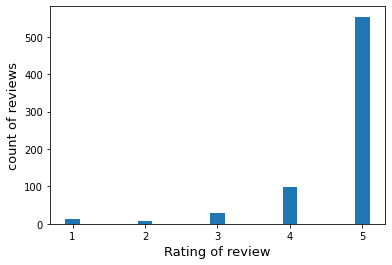

In [ ]:
fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111)
ax.hist(review_df['Rating'], bins=[0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1])
ax.set_xlabel('Rating of review', fontsize=13)
ax.set_ylabel('count of reviews', fontsize=13)
#ax.title('Distribution of reviews', fontsize=15)

(array([ 13.,   0.,   8.,   0.,   0.,  28.,   0.,  97.,   0., 553.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'mean rating given by each reviewer')

Text(0, 0.5, 'number of reviewers')

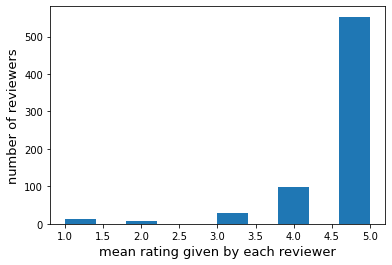

In [ ]:
mean_rating_of_user = review_df.groupby('Review_id').apply(lambda x: x['Rating'].mean())

fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each reviewer', fontsize=13)
ax.set_ylabel('number of reviewers', fontsize=13)

In [ ]:
review_df['Sentiment'] = review_df['Rating'].apply(lambda Rating: 'Positive' if Rating > 3 else 'Negative')
review_df.head(5)

,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Rating,Sentiment
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,5,Positive
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,5,Positive
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,5,Positive
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,4,Positive
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,5,Positive


In [ ]:
review_df['Label'] = review_df['Sentiment'].apply(lambda Sentiment: '1' if Sentiment is 'Positive' else '0')
review_df.head(5)

,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Rating,Sentiment,Label
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,5,Positive,1
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,5,Positive,1
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,5,Positive,1
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,4,Positive,1
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,5,Positive,1


In [ ]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

review_df['Text_Clean'] = review_df['Reviews'].apply(lambda x: remove_punct(x))

In [ ]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in review_df.Text_Clean]


In [ ]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [ ]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [ ]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [ ]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]


In [ ]:
result = [' '.join(sen) for sen in filtered_words]


In [ ]:
review_df['Clean_Reviews'] = result


In [ ]:
review_df['tokens'] = filtered_words


In [ ]:
review_df = review_df[['Hotel_id','Hotel','Review_id','Title','Users','Reviews','Clean_Reviews', 'Rating','tokens','Sentiment', 'Label']]
review_df.head(5)

,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Clean_Reviews,Rating,tokens,Sentiment,Label
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,memorable stay royal orchid central friendly s...,5,"[memorable, stay, royal, orchid, central, frie...",Positive,1
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,things happen time remember long timethe trip ...,5,"[things, happen, time, remember, long, timethe...",Positive,1
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,stay comfortable e delightfulthis ia first vis...,5,"[stay, comfortable, e, delightfulthis, ia, fir...",Positive,1
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,stayed 7 days really happy service provided wo...,4,"[stayed, 7, days, really, happy, service, prov...",Positive,1
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,comfortable stay services staff good ambience ...,5,"[comfortable, stay, services, staff, good, amb...",Positive,1


In [ ]:
review_df['Pos'] = review_df['Label'].apply(lambda Label: '1' if Label is '1' else '0')
review_df.head(50)

,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Clean_Reviews,Rating,tokens,Sentiment,Label,Pos
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,memorable stay royal orchid central friendly s...,5,"[memorable, stay, royal, orchid, central, frie...",Positive,1,1
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,things happen time remember long timethe trip ...,5,"[things, happen, time, remember, long, timethe...",Positive,1,1
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,stay comfortable e delightfulthis ia first vis...,5,"[stay, comfortable, e, delightfulthis, ia, fir...",Positive,1,1
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,stayed 7 days really happy service provided wo...,4,"[stayed, 7, days, really, happy, service, prov...",Positive,1,1
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,comfortable stay services staff good ambience ...,5,"[comfortable, stay, services, staff, good, amb...",Positive,1,1
5,g297628-d503249,Royal Orchid Central,r753023351,Awsm stay,mrinzzzzzzzz,Stay is awsm...staffs are really very helpful ...,stay awsmstaffs really helpful energetic good ...,5,"[stay, awsmstaffs, really, helpful, energetic,...",Positive,1,1
6,g297628-d503249,Royal Orchid Central,r751620440,Very good hotel but!!!,SChoudhury,I and my family were there first for three nig...,family first three nights two nights gap three...,4,"[family, first, three, nights, two, nights, ga...",Positive,1,1
7,g297628-d503249,Royal Orchid Central,r751604420,Good location within walking/auto rickshaw dis...,Patbee1,Had a great couple of nights here. The room wa...,great couple nights room high floor clean well...,4,"[great, couple, nights, room, high, floor, cle...",Positive,1,1
8,g297628-d503249,Royal Orchid Central,r751312659,Good One,Manuel Nelson,This is the Second time i am staying in the sa...,second time staying property service good over...,4,"[second, time, staying, property, service, goo...",Positive,1,1
9,g297628-d503249,Royal Orchid Central,r364142478,Its a value for money place in the heart of Be...,AnoopSaxena,"Located in the heart of the city, this is a go...",located heart city good value money place take...,5,"[located, heart, city, good, value, money, pla...",Positive,1,1


In [ ]:
review_df['Neg'] = review_df['Label'].apply(lambda Label: '0' if Label is '1' else '1')
review_df.head(50)

,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Clean_Reviews,Rating,tokens,Sentiment,Label,Pos,Neg
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,memorable stay royal orchid central friendly s...,5,"[memorable, stay, royal, orchid, central, frie...",Positive,1,1,0
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,things happen time remember long timethe trip ...,5,"[things, happen, time, remember, long, timethe...",Positive,1,1,0
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,stay comfortable e delightfulthis ia first vis...,5,"[stay, comfortable, e, delightfulthis, ia, fir...",Positive,1,1,0
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,stayed 7 days really happy service provided wo...,4,"[stayed, 7, days, really, happy, service, prov...",Positive,1,1,0
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,comfortable stay services staff good ambience ...,5,"[comfortable, stay, services, staff, good, amb...",Positive,1,1,0
5,g297628-d503249,Royal Orchid Central,r753023351,Awsm stay,mrinzzzzzzzz,Stay is awsm...staffs are really very helpful ...,stay awsmstaffs really helpful energetic good ...,5,"[stay, awsmstaffs, really, helpful, energetic,...",Positive,1,1,0
6,g297628-d503249,Royal Orchid Central,r751620440,Very good hotel but!!!,SChoudhury,I and my family were there first for three nig...,family first three nights two nights gap three...,4,"[family, first, three, nights, two, nights, ga...",Positive,1,1,0
7,g297628-d503249,Royal Orchid Central,r751604420,Good location within walking/auto rickshaw dis...,Patbee1,Had a great couple of nights here. The room wa...,great couple nights room high floor clean well...,4,"[great, couple, nights, room, high, floor, cle...",Positive,1,1,0
8,g297628-d503249,Royal Orchid Central,r751312659,Good One,Manuel Nelson,This is the Second time i am staying in the sa...,second time staying property service good over...,4,"[second, time, staying, property, service, goo...",Positive,1,1,0
9,g297628-d503249,Royal Orchid Central,r364142478,Its a value for money place in the heart of Be...,AnoopSaxena,"Located in the heart of the city, this is a go...",located heart city good value money place take...,5,"[located, heart, city, good, value, money, pla...",Positive,1,1,0


In [ ]:
review_df_train, review_df_test = train_test_split(review_df, test_size=0.10, random_state=42)


In [ ]:
all_training_words = [word for tokens in review_df_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in review_df_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

24620 words total, with a vocabulary size of 4740
Max sentence length is 156


In [ ]:
all_test_words = [word for tokens in review_df_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in review_df_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

2791 words total, with a vocabulary size of 1264
Max sentence length is 81


In [ ]:
word2vec_path = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
training_embeddings = get_word2vec_embeddings(word2vec, review_df_train, generate_missing=True)


In [ ]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

In [ ]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(review_df_train["Clean_Reviews"].tolist())
training_sequences = tokenizer.texts_to_sequences(review_df_train["Clean_Reviews"].tolist())
x_test = tokenizer.texts_to_sequences(review_df_train["Clean_Reviews"])

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))


Found 4740 unique tokens.


In [ ]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [ ]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(4741, 300)


In [ ]:
test_sequences = tokenizer.texts_to_sequences(review_df_test["Clean_Reviews"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model
    
    

In [ ]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string

In [ ]:

label_names = ['Pos', 'Neg']

In [ ]:
y_train = review_df_train[label_names].values
y_test=review_df_train[label_names].values


In [ ]:
x_train = train_cnn_data
y_tr = y_train

In [ ]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 50, 300)      1422300     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 49, 200)      120200      embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 48, 200)      180200      embedding_7[0][0]                
_______________________________________________________________________________________

In [ ]:
num_epochs = 3
batch_size = 34

In [ ]:

# Hyperparams if GPU is available
if tf.config.list_physical_devices('GPU'):
    # GPU
    BATCH_SIZE = 128 # Number of examples used in each iteration
    EPOCHS = 2 # Number of passes through entire dataset
    VOCAB_SIZE = 30000 # Size of vocabulary dictionary
    MAX_LEN = 500 # Max length of review (in words)
    EMBEDDING_DIM = 40 # Dimension of word embedding vector

# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 32
    EPOCHS = 2
    VOCAB_SIZE = 20000
    MAX_LEN = 90
    EMBEDDING_DIM = 40

In [ ]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)


1/1 [==============================] - 0s 1ms/step


In [ ]:
labels = [1, 0]


In [ ]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
sum(review_df_test.Label==prediction_labels)/len(prediction_labels)


0.0